In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import optuna
from numpy.linalg import norm
from functools import partial
from scipy.stats import pearsonr

from sklearn.model_selection import TimeSeriesSplit

SEED = 42
random.seed(SEED)
np.random.seed(SEED)         

# Dataset generation

In [15]:
def generate_lorenz(length, dt=0.01, sigma=10.0, rho=28.0, beta=8/3, noise=4):
    
    """
    Args:
        length         (int):      Number of time steps to generate.
        dt             (float):    Time step size.
        sigma          (float):    Lorenz parameter sigma.
        rho            (float):    Lorenz parameter pho.
        beta           (float):    Lorenz parameter beta.
        initial_state  (tuple):    Initial (x0, y0, z0). Random if None.
        noise          (float):    Std-dev of additive Gaussian noise on each variable.
        seed           (int/None): Random seed for reproducibility.

    Returns:
        t  -> time vector
        traj  -> the Lorenz trajectory (x, y, z) at each time.
    """

    rng = np.random.default_rng(SEED)
    state = rng.standard_normal(3)

    t = np.linspace(0, dt*(length-1), length)
    traj = np.zeros((length, 3))
    traj[0] = state

    def lorenz_rhs(s): #definition of lorentz equations
        x, y, z = s
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        return np.array([dx, dy, dz])

    for i in range(1, length):  # 4th-order Runge–Kutta integration
        s = traj[i-1]
        k1 = lorenz_rhs(s)
        k2 = lorenz_rhs(s + 0.5 * dt * k1)
        k3 = lorenz_rhs(s + 0.5 * dt * k2)
        k4 = lorenz_rhs(s + dt * k3)
        traj[i] = s + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    if noise > 0: #eventuale
        traj += np.random.normal(scale=noise, size=traj.shape)

    return t, traj


def lorenz_rhs(state, sigma = 10.0, rho = 28.0, beta = 8/3):
    #Calcola [dx/dt, dy/dt, dz/dt] del Lorenz -> right hand side of the Lorenz equations.
    
    state = np.asarray(state)
    if state.ndim == 2:
        x = state[:, 0]
        y = state[:, 1]
        z = state[:, 2]
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        return np.stack((dx, dy, dz), axis=1)

    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])


def nrmse(y_true, y_pred):
    num = np.linalg.norm(y_true - y_pred)
    den = np.linalg.norm(y_true)
    return num / den


def split_train_val_test(u, y, train_frac=0.6, val_frac=0.2):
    # test_frac = 1 - train_frac - val_frac
    
    if train_frac + val_frac >= 1.0:
        raise ValueError("train_frac + val_frac must be < 1.0")
    N = len(u)
    i_train = int(train_frac * N)
    i_val   = i_train + int(val_frac * N)

    return ((u[:i_train], y[:i_train]), (u[i_train:i_val], y[i_train:i_val]), (u[i_val:], y[i_val:]))

## ESN and PI-ESN Class

In [16]:
class ESN:
    def __init__(
        self,
        in_size: int,
        res_size: int,
        out_size: int,
        spectral_radius: float = 0.95,
        sparsity: float = 0.1,
        input_scaling: float = 1.0,
        leak_rate: float = 1.0,
        ridge_reg: float = 1e-8,
        seed: int = SEED,
        topology: str = "random"
    ):
        
        self.in_size = in_size
        self.res_size = res_size
        self.out_size = out_size
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.input_scaling = input_scaling
        self.leak_rate = leak_rate
        self.ridge_reg = ridge_reg
        self.topology = topology

        self.rng = np.random.default_rng(seed)
        self.Wout = None  # verrà settato in fit()

        # Genera Win e W
        self._init_weights()

    def _init_weights(self):
        """Crea Win e W, quindi scala W per avere lo spectral radius desiderato."""
        N = self.res_size
        # Win: (res_size, in_size+1)
        self.Win = (np.random.rand(self.res_size, self.in_size + 1) - 0.5) * 2 * self.input_scaling

        if self.topology == "random":
            W = self.rng.random((N, N)) - 0.5
            mask = self.rng.random((N, N)) < self.sparsity
            W[mask] = 0.0
        elif self.topology == "ring":
            W = np.zeros((N, N))
            for i in range(N):
                W[i, (i+1) % N] = self.rng.uniform(-0.5, 0.5)
                W[i, (i-1) % N] = self.rng.uniform(-0.5, 0.5)
        elif self.topology == "double_cycle":
            if N % 2 != 0:
                raise ValueError("double_cycle richiede res_size pari")
            W = np.zeros((N, N))
            half = N // 2
            for i in range(N):
                W[i, (i+1) % N]    = self.rng.uniform(-0.5, 0.5)
                W[i, (i-1) % N]    = self.rng.uniform(-0.5, 0.5)
                W[i, (i+half) % N] = self.rng.uniform(-0.5, 0.5)
                W[i, (i-half) % N] = self.rng.uniform(-0.5, 0.5)
        else:
            raise ValueError(f"Topologia '{self.topology}' non riconosciuta")

        eigs = np.linalg.eigvals(W)
        radius = np.max(np.abs(eigs))
        self.W = W * (self.spectral_radius / radius)

    def _update(self, state: np.ndarray, u: np.ndarray) -> np.ndarray:
        #One-step reservoir update (leaky integrator): x' = (1 - α)*x + α * tanh( Win·[1; u] + W·x ).

        u_aug = np.hstack(([1.0], u))  # (in_size + 1,)
        preact = self.Win.dot(u_aug) + self.W.dot(state)
        x_new = (1 - self.leak_rate) * state + self.leak_rate * np.tanh(preact)
        return x_new

    def fit(self, U: np.ndarray, Y: np.ndarray, washout: int = 100):
        """
        Allena la readout Wout tramite ridge-regression.
        U: array di shape (T, in_size) oppure (T,) se in_size=1
        Y: array di shape (T, out_size)
        """
        T = U.shape[0]
        Nf = self.res_size + self.in_size + 1

        # Prealloca X (da washout in poi) e Y_target
        X = np.zeros((T - washout, Nf))
        Y_target = Y[washout:]  # (T-washout, out_size)

        x = np.zeros(self.res_size)
        for t in range(T):
            # garantiamo che U[t] diventi array 1D di lunghezza in_size
            u = np.atleast_1d(U[t])
            x = self._update(x, u)
            if t >= washout:
                feat = np.hstack(([1.0], u, x))
                X[t - washout] = feat

        # Ridge regression chiude-forma
        XtX = X.T.dot(X)
        reg_mat = self.ridge_reg * np.eye(XtX.shape[0])
        Wtilde = np.linalg.inv(XtX + reg_mat)
        self.Wout = Y_target.T.dot(X).dot(Wtilde)  # (out_size, n_features)

    def predict(self, U: np.ndarray, continuation: bool = False) -> np.ndarray:
        """
        Predice la sequenza di output dato l'input U.
        U: (T, in_size) o (T,) se in_size=1.
        Se continuation=True, parte dallo stato di reservoir salvato.
        """
        T = U.shape[0]
        Y_hat = np.zeros((T, self.out_size))

        if continuation and hasattr(self, 'last_state'):
            x = self.last_state.copy()
        else:
            x = np.zeros(self.res_size)

        for t in range(T):
            u = np.atleast_1d(U[t])
            x = self._update(x, u)
            feat = np.hstack(([1.0], u, x))
            Y_hat[t] = self.Wout.dot(feat)

        self.last_state = x.copy()
        return Y_hat

In [17]:
class PIESN(ESN):
    
    def __init__(
        self,
        in_size: int,
        res_size: int,
        out_size: int,
        spectral_radius: float = 0.95,
        sparsity: float = 0.1,
        input_scaling: float = 1.0,
        leak_rate: float = 1.0,
        ridge_reg: float = 1e-8,
        seed: int = SEED,
        topology: str = "random",
        lambda_data: float = 1.0,
        lambda_phys: float = 0.01,
        ode_func=None,
        delta_t: float = 0.01,
        phys_horizon: int = 10,
        full_closed_loop: bool = False,
        curriculum: bool = False,
        curr_tau: float = 10.0
    ):
        super().__init__(
            in_size        = in_size,
            res_size       = res_size,
            out_size       = out_size,
            spectral_radius= spectral_radius,
            sparsity       = sparsity,
            input_scaling  = input_scaling,
            leak_rate      = leak_rate,
            ridge_reg      = ridge_reg,
            seed           = seed,
            topology       = topology
        )
        self.lambda_data      = lambda_data
        self.lambda_phys      = lambda_phys
        self.ode_func         = ode_func
        self.delta_t          = delta_t
        self.phys_horizon     = phys_horizon
        self.full_closed_loop = full_closed_loop
        self.curriculum       = curriculum
        self.curr_tau         = curr_tau
        self.curr_step        = 0

        self._mean_U = None  
        self._std_U  = None  

        # Stato del reservoir da ereditare se continuation=True
        self.last_state = None

    def _compute_data_loss(self, W_flat, X, Y_target):
        #Data‐loss = MSE + ridge_reg * ||Wout||^2
        
        Wout = W_flat.reshape(self.out_size, self.res_size)  # (out_size, res_size)
        Y_pred = X.dot(Wout.T)                               # (T-washout, out_size)
        mse    = np.mean((Y_pred - Y_target) ** 2)
        reg    = self.ridge_reg * np.sum(Wout ** 2)
        return mse + reg

    def _compute_physics_loss(self, W_flat, Y0 ,U_seq):
        #Physics-loss su phys_horizon passi futuri:
        
        N    = self.phys_horizon
        Wout = W_flat.reshape(self.out_size, self.res_size)  # (out_size, res_size)
        x    = np.zeros(self.res_size)
        Y_pred = [Y0.copy()]  # lista di vettori (out_size,)

        for n in range(N):
            u = np.atleast_1d(U_seq[n])       # (in_size,)
            feat = x                         # (res_size,) → solo reservoir
            y_next = Wout.dot(feat)          # (out_size,)
            Y_pred.append(y_next)

            if self.full_closed_loop:
                x = self._update(x, y_next)
            else:
                x = self._update(x, u)

        Y_pred = np.stack(Y_pred)             # (N+1, out_size)
        dY     = (Y_pred[1:] - Y_pred[:-1]) / self.delta_t  # (N, out_size)

        try:
            F = self.ode_func(Y_pred[:-1])    # (N, out_size)
        except:
            F = np.vstack([self.ode_func(y) for y in Y_pred[:-1]])

        res = dY - F                          # (N, out_size)
        phys_loss = np.mean(res ** 2)

        if self.curriculum: #Se curriculum=True, moltiplica per curr_factor
            curr_factor = 1 - np.exp(- self.curr_step / self.curr_tau)
            self.curr_step += 1
        else:
            curr_factor = 1.0

        return curr_factor * phys_loss

    def _total_loss(self, W_flat, X, Y_target, Y0, U_seq):
          #L = lambda_data * Ld + lambda_phys * Lp

        Ld = self._compute_data_loss(W_flat, X, Y_target)
        Lp = self._compute_physics_loss(W_flat, Y0, U_seq)
        return self.lambda_data * Ld + self.lambda_phys * Lp

    def fit_physics(self, U, Y, washout = 100):

        """
        Esegue addestramento PI-ESN:
          1. Normalizza (U,Y) con Z-score
          2. Propaga reservoir su U_norm per raccogliere tutti gli stati (states)
          3. Costruisce X = states[washout:]  e Y_target = Y_norm[washout:]
             ⇒ X ha shape (T-washout, res_size)
          4. Risolve regressione ridge iniziale su (X, Y_target)
             ⇒ W0 piatto di shape (out_size * res_size)
          5. Minimizza L = data_loss + physics_loss con L-BFGS-B
        Ritorna OptimizeResult di SciPy.
        """
        T = U.shape[0]
        N = self.phys_horizon

        # 1) Normalizzazione Z‐score
        mean_U = U.mean(axis=0)          # (in_size,)
        std_U  = U.std(axis=0) + 1e-8
        U_norm = (U - mean_U) / std_U     # (T, in_size)
        Y_norm = (Y - mean_U) / std_U     # (T, out_size)

        self._mean_U = mean_U.copy()
        self._std_U  = std_U.copy()

        # Propago il reservoir e salvo gli stati in “states”
        x_state = np.zeros(self.res_size)
        states = np.zeros((T, self.res_size))  # (T, res_size)
        for t_i in range(T):
            u_i = np.atleast_1d(U_norm[t_i])   # (in_size,)
            x_state = self._update(x_state, u_i)
            states[t_i] = x_state

        # Costruisco X, Y_target dopo washout
        X = states[washout:]           # (T-washout, res_size)
        Y_target = Y_norm[washout:]    # (T-washout, out_size)

        # Verifica condizione physics horizon
        if T < washout + 2 * N:
            raise ValueError("Serve T >= washout + 2 * phys_horizon")

        # Preparo Y0 e U_seq normalizzati per physics_loss
        idx0 = washout + N
        Y0   = Y_norm[idx0]                 # (out_size,)
        U_seq = U_norm[idx0 : idx0 + N]      # (N, in_size)

        # Soluzione iniziale ridge-only (X, Y_target)
        XtX = X.T.dot(X)                     # (res_size, res_size)
        reg_mat = self.ridge_reg * np.eye(self.res_size)
        W_ridge = np.linalg.solve(XtX + reg_mat, X.T.dot(Y_target))
        # W_ridge ha shape (res_size, out_size)
        W0 = W_ridge.T.flatten()             # (out_size * res_size,)

        # Minimizzazione loss totale con L-BFGS-B
        self.curr_step = 0
        result = minimize(
            fun    = self._total_loss,
            x0     = W0,
            args   = (X, Y_target, Y0, U_seq),
            method = 'L-BFGS-B'
        )

        W_opt = result.x.reshape(self.out_size, self.res_size)  # (out_size, res_size)
        self.Wout = W_opt.copy()
        return result

    def predict(self,U, continuation = False):
        """
        1. Normalizza U usando (mean_U, std_U)
        2. Propaga reservoir e raccoglie gli stati x_t
        3. Calcola Y_hat_norm[t] = Wout ⋅ x_t
        4. De-normalizza: Y_hat = Y_hat_norm * std_U + mean_U
        5. Se continuation=True, eredita last_state
        """
        U_norm = (U - self._mean_U) / self._std_U  # (T_te, in_size)
        T = U_norm.shape[0]
        Y_hat_norm = np.zeros((T, self.out_size))  # (T_te, out_size)

        if continuation and hasattr(self, "last_state"):
            x = self.last_state.copy()
        else:
            x = np.zeros(self.res_size)

        for t_i in range(T):
            u_i = np.atleast_1d(U_norm[t_i])
            x = self._update(x, u_i)           # (res_size,)
            Y_hat_norm[t_i] = self.Wout.dot(x) # (out_size,)

        self.last_state = x.copy()
        return (Y_hat_norm * self._std_U) + self._mean_U

In [18]:
def objective(trial):
    params = {
        "in_size":         3,
        "out_size":        3,
        "res_size":       trial.suggest_int("res_size",      256, 1024, step=2),
        "spectral_radius":trial.suggest_float("rho",        0.1, 0.3, log=True),
        "sparsity":       trial.suggest_float("sparsity",   0.01, 0.05, log=True),
        "input_scaling":  trial.suggest_float("in_scale",   0.1, 1.0),
        "leak_rate":      trial.suggest_float("alpha",      0.2, 0.5),
        "ridge_reg":      trial.suggest_float("ridge_reg",  1e-6, 1e-3, log=True),
        "topology":       trial.suggest_categorical("topo",   ["random","ring","double_cycle"]),
        # pesi fisica vs dati
        "lambda_data":    trial.suggest_float("λ_data",     0.5, 3.0, log=True),
        "lambda_phys":    trial.suggest_float("λ_phys",     1e-2, 0.5, log=True),
        "phys_horizon":   trial.suggest_int("horizon",      3,   7),
    }

    fold_scores = []
    for train_idx, val_idx in tscv.split(U):
        u_tr,  u_val  = U[train_idx],  U[val_idx]
        y_tr,  y_val  = Y[train_idx],  Y[val_idx]

        piesn = PIESN(
            **params,
            seed=SEED,
            ode_func=lorenz_rhs,
            delta_t=dt,
            full_closed_loop=True,
            curriculum=True,
            curr_tau=10.0
        )

        piesn.fit_physics(u_tr, y_tr, washout=100)

        y_val_pred = piesn.predict(u_val, continuation=False)

        score = nrmse_multi(y_val[100:], y_val_pred[100:])
        fold_scores.append(score)

    return float(np.mean(fold_scores))

## Optuna tuning

In [19]:
# import optuna
# import numpy as np
# from sklearn.model_selection import TimeSeriesSplit

# # fisso seme e split
# SEED = 42
# tscv = TimeSeriesSplit(n_splits=4)

# # Genera dati Lorenz (senza rumore per test; aggiungeremo rumore poi)
# dt = 0.01
# length = 10000
# np.random.seed(SEED)
# t, traj = generate_lorenz(length=length, dt=dt, noise=0.0) 

# # Multivariato: U = [x,y,z]_t, Y = [x,y,z]_{t+1}
# U = traj[:-1]   # shape = (9999, 3)
# Y = traj[1:]    # shape = (9999, 3)

# def nrmse_multi(y_true: np.ndarray, y_pred: np.ndarray) -> float:
#     num = np.linalg.norm(y_true - y_pred)
#     den = np.linalg.norm(y_true)
#     return num / den

# def objective(trial):
#     # ───────────────────────────────────────────────────────────────────────
#     # 1) Ipparametri da ottimizzare
#     params = {
#         "in_size":         3,
#         "out_size":        3,
#         "res_size":       trial.suggest_int("res_size",      256, 1024, step=2),
#         "spectral_radius":trial.suggest_float("rho",        0.1, 0.3, log=True),
#         "sparsity":       trial.suggest_float("sparsity",   0.01, 0.05, log=True),
#         "input_scaling":  trial.suggest_float("in_scale",   0.1, 1.0),
#         "leak_rate":      trial.suggest_float("alpha",      0.2, 0.5),
#         "ridge_reg":      trial.suggest_float("ridge_reg",  1e-6, 1e-3, log=True),
#         "topology":       trial.suggest_categorical("topo",   ["random","ring","double_cycle"]),
#         # physics ‐ informed:
#         "lambda_data":    trial.suggest_float("λ_data",     0.5, 3.0, log=True),
#         "lambda_phys":    trial.suggest_float("λ_phys",    1e-2, 0.5, log=True),
#         "phys_horizon":   trial.suggest_int("horizon",      3,  7),
#     }

#     fold_scores = []
#     # ───────────────────────────────────────────────────────────────────────
#     # 2) Loop sui 4 fold forward‐chaining
#     for train_idx, val_idx in tscv.split(U):
#         u_tr, u_val = U[train_idx], U[val_idx]   # (N_train,3), (N_val,3)
#         y_tr, y_val = Y[train_idx], Y[val_idx]   # (N_train,3), (N_val,3)

#         # ───────────────────────────────────────────────────────────────────
#         # 3) Crea e allena PIESN “migliorato”
#         piesn = PIESN(
#             **params,
#             seed=SEED,
#             ode_func=lorenz_rhs,
#             delta_t=dt,
#             full_closed_loop=True,     # costantemente attivo
#             curriculum=True,           # attivo il curriculum
#             curr_tau=10.0
#         )
#         piesn.fit_physics(u_tr, y_tr, washout=100)

#         # ───────────────────────────────────────────────────────────────────
#         # 4) Predizione su validazione
#         y_val_pred = piesn.predict(u_val, continuation=False)  # (N_val,3)

#         # ───────────────────────────────────────────────────────────────────
#         # 5) NRMSE su validazione a partire dal step 100
#         score = nrmse_multi(y_val[100:], y_val_pred[100:])
#         fold_scores.append(score)

#     # ───────────────────────────────────────────────────────────────────────
#     # 6) Ritorna media dei 4 fold
#     return float(np.mean(fold_scores))


# # ────────────────────────────────────────────────────────────────────────────
# # Lancio Optuna
# # ────────────────────────────────────────────────────────────────────────────
# study = optuna.create_study(
#     direction="minimize",
#     sampler=optuna.samplers.TPESampler(seed=SEED)
# )
# study.optimize(objective, n_trials=100)

# print("Best hyper-parameters:", study.best_params)
# print("Best CV NRMSE:", study.best_value)


# ### BEST PARAMETERS
# # Best hyper-parameters: {'res_size': 702, 'rho': 0.2984420995798068, 'sparsity': 0.018373476919717507, 'in_scale': 0.11767292203090399, 'alpha': 0.46063074737767395, 'ridge_reg': 1.0027704994452981e-06, 'topo': 'double_cycle', 'λ_data': 0.649881735137383, 'λ_phys': 0.01768950152554423, 'horizon': 6}
# # Best CV NRMSE: 2.631539405758465e-05

One step error computation

In [41]:
##one step prediction with noise

length = 10000
dt= 0.01

best = {'res_size': 702, 'rho': 0.2984420995798068, 'sparsity': 0.018373476919717507, 'in_scale': 0.11767292203090399, 'alpha': 0.46063074737767395, 'ridge_reg': 1.0027704994452981e-06, 'topo': 'double_cycle', 'λ_data': 0.649881735137383, 'λ_phys': 0.01768950152554423, 'horizon': 6}

results = []
noise_levels = [1,2,3,4,5]

for noise in noise_levels:
   
    np.random.seed(SEED)
    t, traj_noisy = generate_lorenz(length=length, dt=dt, noise=noise)

    U_noisy = traj_noisy[:-1]   
    Y_noisy = traj_noisy[1:]    

    (u_tr, y_tr), (u_val, y_val), (u_te, y_te) = split_train_val_test(U_noisy, Y_noisy, train_frac=0.6, val_frac=0.2)

    piesn_final = PIESN(
        in_size=3,
        res_size=best['res_size'],
        out_size=3,
        spectral_radius=best['rho'],
        sparsity=best['sparsity'],
        input_scaling=best['in_scale'],
        leak_rate=best['alpha'],
        ridge_reg=best['ridge_reg'],
        seed=SEED,
        topology=best['topo'],
        lambda_data=best['λ_data'],
        lambda_phys=best['λ_phys'],
        ode_func=lorenz_rhs,
        delta_t=dt,
        phys_horizon=best['horizon'],
        full_closed_loop=False,
        curriculum=True,
        curr_tau=10.0
    )
    piesn_final.fit_physics(u_tr, y_tr, washout=100)
    y_pred_piesn = piesn_final.predict(u_te, continuation=False)
    nrmse_piesn = norm(y_te[100:] - y_pred_piesn[100:]) / norm(y_te[100:])

    esn_only = ESN(
        in_size=3,
        res_size=best['res_size'],
        out_size=3,
        spectral_radius=best['rho'],
        sparsity=best['sparsity'],
        input_scaling=best['in_scale'],
        leak_rate=best['alpha'],
        ridge_reg=best['ridge_reg'],
        seed=SEED,
        topology=best['topo']
    )
    esn_only.fit(u_tr, y_tr, washout=100)
    y_pred_esn = esn_only.predict(u_te, continuation=False)
    nrmse_esn = norm(y_te[100:] - y_pred_esn[100:]) / norm(y_te[100:])

    results.append({
        "noise_level": noise,
        "nrmse_piesn": nrmse_piesn,
        "nrmse_esn":   nrmse_esn
    })

df_results = pd.DataFrame(results)
df_results

,noise_level,nrmse_piesn,nrmse_esn
0,1,0.064674,0.070993
1,2,0.129019,0.148172
2,3,0.192454,0.228380
3,4,0.254207,0.291680
4,5,0.313601,0.348237


In [39]:
#computer the variance of y_true
variance_y_true = np.var(y_te)
print(f"Varianza di y_true: {variance_y_true:.4f}")

Varianza di y_true: 178.1025


In [22]:
# import numpy as np
# import optuna
# from sklearn.model_selection import TimeSeriesSplit


# SEED = 42
# tscv = TimeSeriesSplit(n_splits=4)

# dt = 0.01
# length = 10000
# np.random.seed(SEED)

# # (2) Generate a full 3D Lorenz trajectory
# #     traj has shape (10000, 3)
# t, traj = generate_lorenz(length=length, dt=dt)

# # We will predict [x(t+1),y(t+1),z(t+1)] from [x(t),y(t),z(t)]:
# U = traj[:-1]  # shape = (9999, 3)
# Y = traj[1:]   # shape = (9999, 3)

# # Normalized RMSE over all 3 coordinates:
# def nrmse_multi(y_true: np.ndarray, y_pred: np.ndarray) -> float:
#     num = np.linalg.norm(y_true - y_pred)
#     den = np.linalg.norm(y_true)
#     return num / den


# def objective(trial):
#     # ─────────────────────────────────────────────────────────────────────────
#     # Step 1: extract hyperparameters, including in_size=3, out_size=3
#     params = {
#         "in_size":         3,  # we feed all three coords
#         "out_size":        3,
#         "res_size":       trial.suggest_int("res_size",  256, 1024, step=2),
#         "spectral_radius":trial.suggest_float("rho",    0.1, 0.3, log=True),
#         "sparsity":       trial.suggest_float("sparsity", 0.01, 0.05, log=True),
#         "input_scaling":  trial.suggest_float("in_scale", 0.1, 1.0),
#         "leak_rate":      trial.suggest_float("alpha",   0.2, 0.5),
#         "ridge_reg":      trial.suggest_float("ridge",   1e-8, 1e-3, log=True),
#         "topology":       trial.suggest_categorical(
#                               "topo", ["random", "ring", "double_cycle"]
#                           ),
#         # physics‐informed weights
#         "lambda_data":    trial.suggest_float("λ_data",  0.1, 10.0, log=True),
#         "lambda_phys":    trial.suggest_float("λ_phys",   1e-4, 1.0, log=True),
#     }

#     fold_scores = []
#     # ─────────────────────────────────────────────────────────────────────────
#     # Step 2: perform 4‐fold forward‐chaining CV on U (shape (9999,3))
#     for train_idx, val_idx in tscv.split(U):
#         u_tr, u_val = U[train_idx], U[val_idx]   # shapes: (N_train,3), (N_val,3)
#         y_tr, y_val = Y[train_idx], Y[val_idx]   # shapes: (N_train,3), (N_val,3)

#         # ─────────────────────────────────────────────────────────────────────
#         # Step 3: build & train PIESN on the 3D data
#         piesn = PIESN(
#             **params,
#             seed=SEED,
#             ode_func=lorenz_rhs,   # accepts shape (3,) or (N,3)
#             delta_t=dt,
#             phys_horizon=10
#         )
#         piesn.fit_physics(u_tr, y_tr, washout=100)

#         # ─────────────────────────────────────────────────────────────────────
#         # Step 4: predict on the validation block
#         y_val_pred = piesn.predict(u_val, continuation=False)  
#         # y_val_pred has shape (N_val,3)

#         # ─────────────────────────────────────────────────────────────────────
#         # Step 5: compute NRMSE on the last N_val-100 steps
#         score = nrmse_multi(y_val[100:], y_val_pred[100:])
#         fold_scores.append(score)

#     # ─────────────────────────────────────────────────────────────────────────
#     # Step 6: return the mean NRMSE across folds
#     return float(np.mean(fold_scores))


# # ───────────────────────────────────────────────────────────────────────────────
# # Run Optuna 
# # ───────────────────────────────────────────────────────────────────────────────
# study = optuna.create_study(
#     direction="minimize",
#     sampler=optuna.samplers.TPESampler(seed=SEED)
# )
# study.optimize(objective, n_trials=100)

# print("Best hyper-parameters:", study.best_params)
# print("Best CV NRMSE:       ", study.best_value)

## NOISE 0
# Best hyper-parameters: {'res_size': 838, 'rho': 0.11132324374382138, 'sparsity': 0.022006426912244036, 'in_scale': 0.894456717602317, 'alpha': 0.23667885731916571, 'ridge': 2.8139472808565623e-06, 'topo': 'double_cycle', 'λ_data': 9.081249292070543, 'λ_phys': 0.00011783565254400636}
# Best CV NRMSE:        0.006853073687520822

# [I 2025-06-01 09:28:43,692] Trial 0 finished with value: 0.01131839905100609 and parameters: {'res_size': 544, 'rho': 0.2841881747862225, 'sparsity': 0.032481928697702896, 'in_scale': 0.6387926357773329, 'alpha': 0.24680559213273096, 'ridge': 6.02521573620385e-08, 'topo': 'ring', 'λ_data': 2.6070247583707675, 'λ_phys': 0.00012087541473056971}. Best is trial 0 with value: 0.01131839905100609.
# [I 2025-06-01 09:30:05,495] Trial 1 finished with value: 0.045703767192384746 and parameters: {'res_size': 1002, 'rho': 0.2495606322710888, 'sparsity': 0.014074036373847479, 'in_scale': 0.26364247048639056, 'alpha': 0.2550213529560302, 'ridge': 3.3205591037519537e-07, 'topo': 'random', 'λ_data': 1.673808578875213, 'λ_phys': 0.0003613894271216529}. Best is trial 0 with value: 0.01131839905100609.

## NOISE 1
# Best hyper-parameters: {'res_size': 892, 'rho': 0.1057985243322232, 'sparsity': 0.02701562967067657, 'in_scale': 0.17977134462142658, 'alpha': 0.43643389982837566, 'ridge': 0.0004705002647264596, 'topo': 'double_cycle', 'λ_data': 2.6343821511928205, 'λ_phys': 0.0001132231569887812}
# Best CV NRMSE:        0.13599566215684178

## NOISE 1.5
# Best hyper-parameters: {'res_size': 666, 'rho': 0.1662945945073591, 'sparsity': 0.037123482730179125, 'in_scale': 0.12087060964938645, 'alpha': 0.48936255764839875, 'ridge': 0.0006556611365373689, 'topo': 'double_cycle', 'λ_data': 6.021598265070527, 'λ_phys': 0.00015726603958635707}
# Best CV NRMSE:        0.128821324067114

# [I 2025-06-01 12:14:53,497] Trial 0 finished with value: 16.89950571066443 and parameters: {'res_size': 544, 'rho': 0.2841881747862225, 'sparsity': 0.032481928697702896, 'in_scale': 0.6387926357773329, 'alpha': 0.24680559213273096, 'ridge': 6.02521573620385e-08, 'topo': 'ring', 'λ_data': 2.6070247583707675, 'λ_phys': 0.00012087541473056971}. Best is trial 0 with value: 16.89950571066443.
# [I 2025-06-01 12:16:14,353] Trial 1 finished with value: 3.8562126971003488 and parameters: {'res_size': 1002, 'rho': 0.2495606322710888, 'sparsity': 0.014074036373847479, 'in_scale': 0.26364247048639056, 'alpha': 0.2550213529560302, 'ridge': 3.3205591037519537e-07, 'topo': 'random', 'λ_data': 1.673808578875213, 'λ_phys': 0.0003613894271216529}. Best is trial 1 with value: 3.8562126971003488.

## NOISE 2
# Best hyper-parameters: {'res_size': 836, 'rho': 0.13555174728039993, 'sparsity': 0.04609560846329706, 'in_scale': 0.18631551895211307, 'alpha': 0.37865516639597774, 'ridge': 0.000712742116039969, 'topo': 'ring', 'λ_data': 2.5128441079031827, 'λ_phys': 0.00019913712630891973}
# Best CV NRMSE:        0.20058440704892666

## NOISE 4





Multistep error computation

/var/folders/5k/gpnrmhzx1_g61567v3vr7ysh0000gn/T/ipykernel_31826/139248680.py:107: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.loc[d['PI_noisy'].idxmin(), 'lambda_phys'])


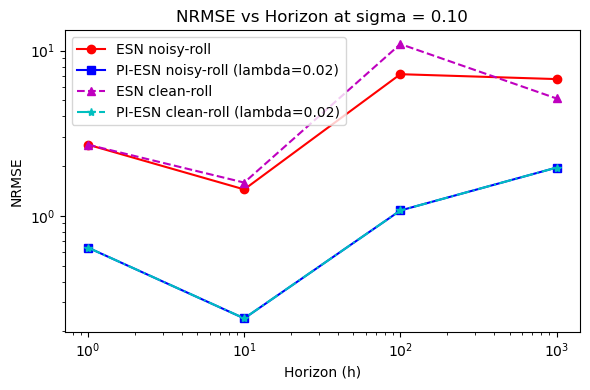

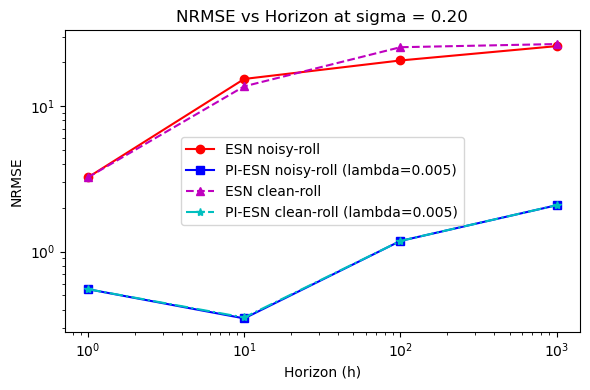

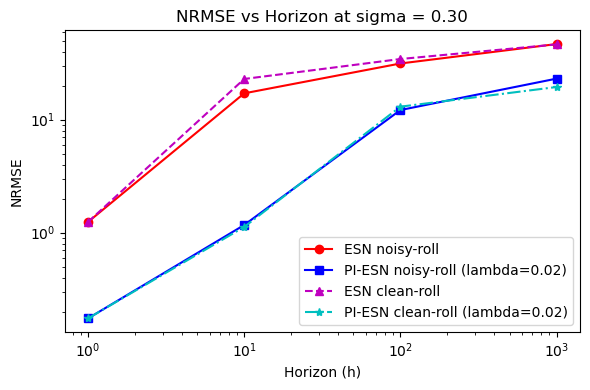

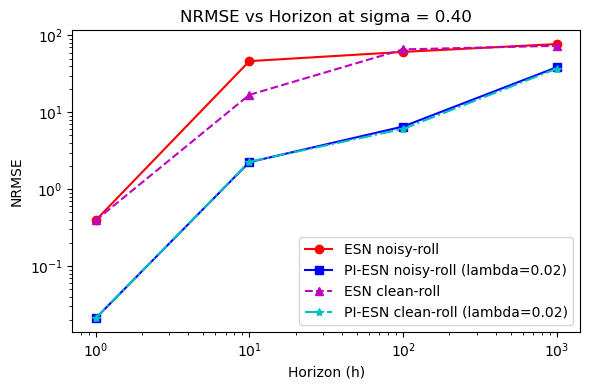

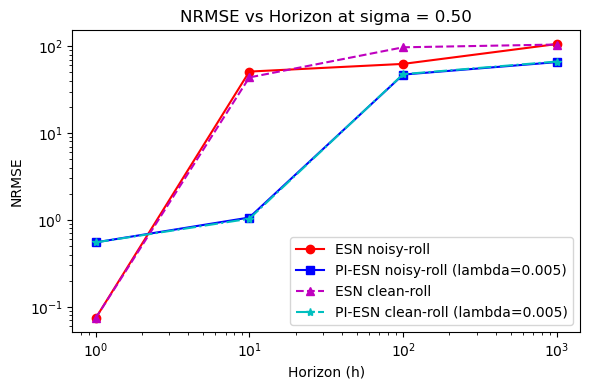

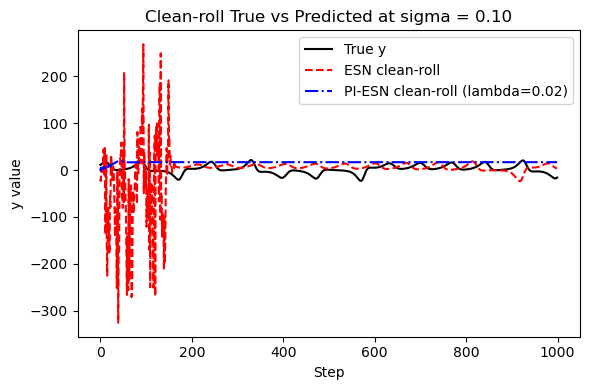

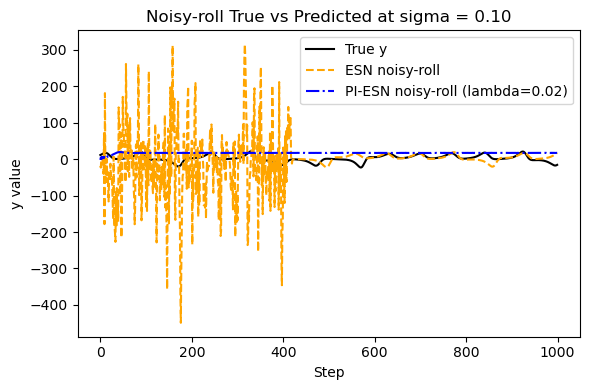

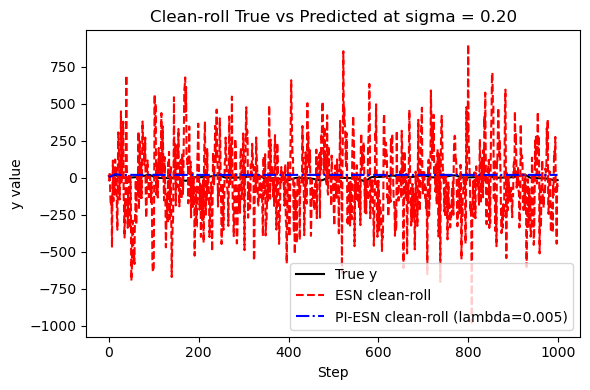

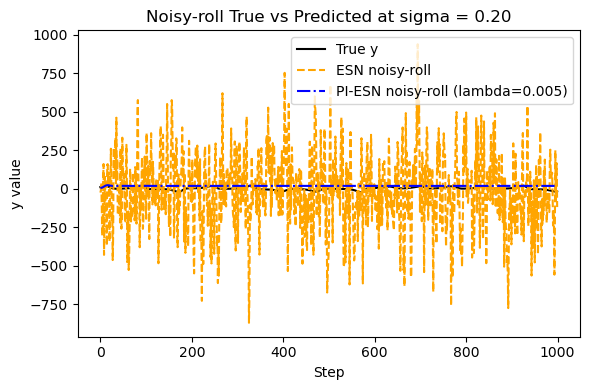

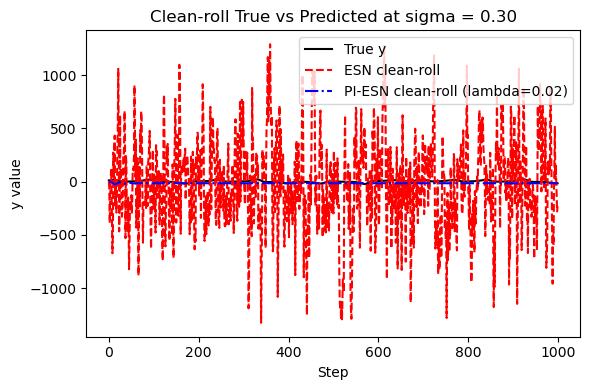

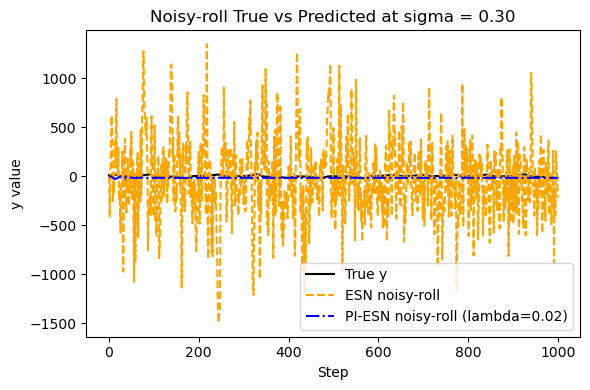

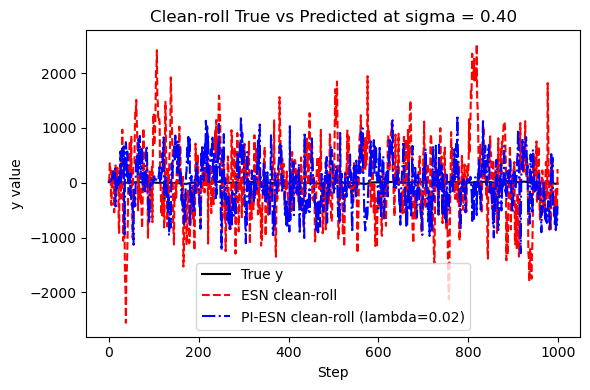

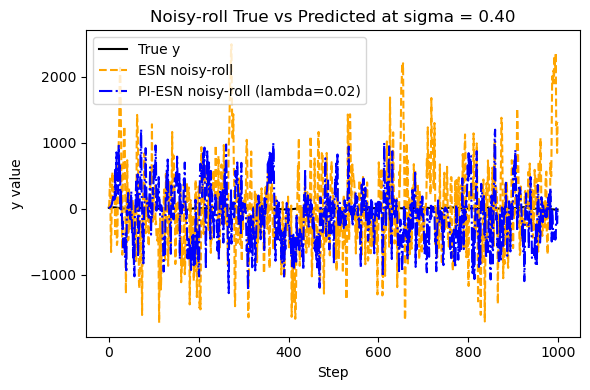

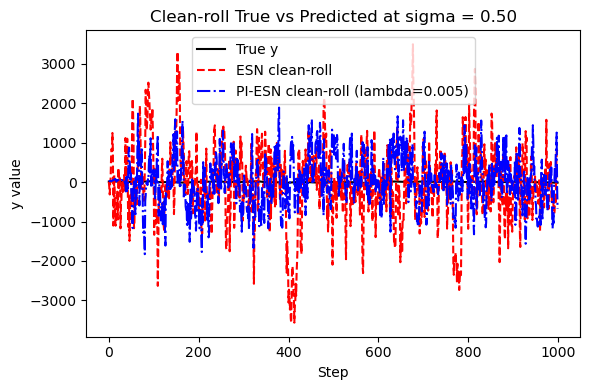

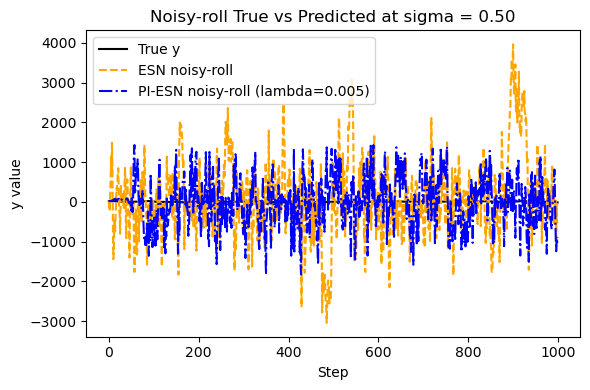

In [40]:
best = {
    'res_size':   702,
    'rho':        0.2984420995798068,
    'sparsity':   0.018373476919717507,
    'in_scale':   0.11767292203090399,
    'alpha':      0.46063074737767395,
    'ridge_reg':  1.0027704994452981e-06,
    'topo':       'double_cycle',
    'λ_data':     0.649881735137383,
    'horizon':    6
}

SEED, dt, length = 42, 0.01, 6000
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
horizons = [1, 10, 100, 1000]
lambda_phys_grid = [0.005, 0.01, 0.02, 0.05]

def roll(model, u0, steps, sigma=0, rng=None):
    y = model.predict(u0.reshape(1, -1), continuation=False)[0]
    out = [y.copy()]
    for _ in range(steps - 1):
        if sigma:
            y_in = y + rng.normal(scale=sigma, size=y.shape)
        else:
            y_in = y
        y = model.predict(y_in.reshape(1, -1), continuation=True)[0]
        out.append(y.copy())
    return np.stack(out)[:, 1]

def nrmse(true, pred):
    return norm(true - pred) / norm(true)

#  Genera una sola volta la traiettoria pulita per il test
np.random.seed(SEED)
_, traj_clean = generate_lorenz(length=length, dt=dt, noise=0.0)
U_clean, Y_clean = traj_clean[:-1], traj_clean[1:]
(_, _), (_, _), (u_te, y_te) = split_train_val_test(U_clean, Y_clean, train_frac=0.6, val_frac=0.2)
y_true = y_te[:, 1]

rows = []
for sigma in noise_levels:
    np.random.seed(SEED)
    _, traj_noisy = generate_lorenz(length=length, dt=dt, noise=sigma)
    U_noisy, Y_noisy = traj_noisy[:-1], traj_noisy[1:]
    (u_tr, y_tr), (_, _), _ = split_train_val_test(U_noisy, Y_noisy, train_frac=0.6, val_frac=0.2)

    esn = ESN(
        in_size=3,
        res_size=best['res_size'],
        out_size=3,
        spectral_radius=best['rho'],
        sparsity=best['sparsity'],
        input_scaling=best['in_scale'],
        leak_rate=best['alpha'],
        ridge_reg=best['ridge_reg'],
        seed=SEED,
        topology=best['topo']
    )
    esn.fit(u_tr, y_tr, washout=100)
    rng_esn = np.random.default_rng(int(1e6 * sigma) + SEED)

    # Prova diversi lambda_phys per PI-ESN
    for lp in lambda_phys_grid:
        pi = PIESN(
            in_size         = 3,
            res_size        = best['res_size'],
            out_size        = 3,
            spectral_radius = best['rho'],
            sparsity        = best['sparsity'],
            input_scaling   = best['in_scale'],
            leak_rate       = best['alpha'],
            ridge_reg       = best['ridge_reg'],
            seed            = SEED,
            topology        = best['topo'],
            lambda_data     = best['λ_data'],
            lambda_phys     = lp,
            ode_func        = lorenz_rhs,
            delta_t         = dt,
            phys_horizon    = best['horizon'],
            full_closed_loop= True,
            curriculum      = False
        )
        pi.fit_physics(u_tr, y_tr, washout=100)
        rng_pi = np.random.default_rng(int(1e6 * sigma) + SEED + int(lp * 1e3))

        esn_noisy = roll(esn, u_te[0], max(horizons), sigma, rng_esn)
        pi_noisy  = roll(pi,  u_te[0], max(horizons), sigma, rng_pi)
        esn_clean = roll(esn, u_te[0], max(horizons))
        pi_clean  = roll(pi,  u_te[0], max(horizons))

        for h in horizons:
            rows.append({
                'sigma': sigma,
                'lambda_phys': lp,
                'h': h,
                'ESN_noisy': nrmse(y_true[:h], esn_noisy[:h]),
                'PI_noisy':  nrmse(y_true[:h], pi_noisy[:h]),
                'ESN_clean': nrmse(y_true[:h], esn_clean[:h]),
                'PI_clean':  nrmse(y_true[:h], pi_clean[:h])
            })

df = pd.DataFrame(rows)

best_lps = (
    df[df['h'] == 10]
    .groupby('sigma')
    .apply(lambda d: d.loc[d['PI_noisy'].idxmin(), 'lambda_phys'])
    .to_dict()
)


for sigma in noise_levels:
    lp_best = best_lps[sigma]
    subset = df[(df['sigma'] == sigma) & (df['lambda_phys'] == lp_best)]
    plt.figure(figsize=(6, 4))
    plt.plot(horizons, subset['ESN_noisy'], 'r-o', label='ESN noisy-roll')
    plt.plot(horizons, subset['PI_noisy'],  'b-s', label=f'PI-ESN noisy-roll (lambda={lp_best})')
    plt.plot(horizons, subset['ESN_clean'],'m--^', label='ESN clean-roll')
    plt.plot(horizons, subset['PI_clean'], 'c-.*', label=f'PI-ESN clean-roll (lambda={lp_best})')
    plt.xlabel('Horizon (h)')
    plt.ylabel('NRMSE')
    plt.title(f'NRMSE vs Horizon at sigma = {sigma:.2f}')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()

hmax = max(horizons)
for sigma in noise_levels:
    lp_best = best_lps[sigma]

    # Riallena ESN e PI-ESN con lambda_phys ottimale
    np.random.seed(SEED)
    _, traj_noisy = generate_lorenz(length=length, dt=dt, noise=sigma)
    U_noisy, Y_noisy = traj_noisy[:-1], traj_noisy[1:]
    (u_tr, y_tr), (_, _), _ = split_train_val_test(U_noisy, Y_noisy, train_frac=0.6, val_frac=0.2)

    esn = ESN(
        in_size=3,
        res_size=best['res_size'],
        out_size=3,
        spectral_radius=best['rho'],
        sparsity=best['sparsity'],
        input_scaling=best['in_scale'],
        leak_rate=best['alpha'],
        ridge_reg=best['ridge_reg'],
        seed=SEED,
        topology=best['topo']
    )
    esn.fit(u_tr, y_tr, washout=100)
    rng_esn = np.random.default_rng(int(1e6 * sigma) + SEED)

    pi = PIESN(
        in_size         = 3,
        res_size        = best['res_size'],
        out_size        = 3,
        spectral_radius = best['rho'],
        sparsity        = best['sparsity'],
        input_scaling   = best['in_scale'],
        leak_rate       = best['alpha'],
        ridge_reg       = best['ridge_reg'],
        seed            = SEED,
        topology        = best['topo'],
        lambda_data     = best['λ_data'],
        lambda_phys     = lp_best,
        ode_func        = lorenz_rhs,
        delta_t         = dt,
        phys_horizon    = best['horizon'],
        full_closed_loop= True,
        curriculum      = False
    )
    pi.fit_physics(u_tr, y_tr, washout=100)
    rng_pi = np.random.default_rng(int(1e6 * sigma) + SEED + int(lp_best * 1e3))

    esn_clean = roll(esn, u_te[0], hmax, sigma=0, rng=None)
    pi_clean = roll(pi,  u_te[0], hmax, sigma=0, rng=None)

    esn_noisy = roll(esn, u_te[0], hmax, sigma, rng_esn)
    pi_noisy  = roll(pi,  u_te[0], hmax, sigma, rng_pi)

    idx = np.arange(hmax)

    plt.figure(figsize=(6, 4))
    plt.plot(idx, y_true[:hmax], 'k-', label='True y')
    plt.plot(idx, esn_clean[:hmax], 'r--', label='ESN clean-roll')
    plt.plot(idx, pi_clean[:hmax],  'b-.', label=f'PI-ESN clean-roll (lambda={lp_best})')
    plt.xlabel('Step')
    plt.ylabel('y value')
    plt.title(f'Clean-roll True vs Predicted at sigma = {sigma:.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(idx, y_true[:hmax], 'k-', label='True y')
    plt.plot(idx, esn_noisy[:hmax], '--', color='orange', label='ESN noisy-roll')
    plt.plot(idx, pi_noisy[:hmax],  'b-.', label=f'PI-ESN noisy-roll (lambda={lp_best})')
    plt.xlabel('Step')
    plt.ylabel('y value')
    plt.title(f'Noisy-roll True vs Predicted at sigma = {sigma:.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# --- 1) Keep your existing imports and helper functions ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm

best = {
    'res_size':   702,
    'rho':        0.2984420995798068,
    'sparsity':   0.018373476919717507,
    'in_scale':   0.11767292203090399,
    'alpha':      0.46063074737767395,
    'ridge_reg':  1.0027704994452981e-06,
    'topo':       'double_cycle',
    'λ_data':     0.649881735137383,
    'horizon':    6
}

def compute_nrmse(true, pred):
    return np.linalg.norm(true - pred) / np.linalg.norm(true)

def forecast_horizon(true_seq, pred_seq, threshold=1.0):
    L = len(true_seq)
    norm_true = np.linalg.norm(true_seq)
    if norm_true == 0:
        return 0
    for k in range(1, L + 1):
        err = np.linalg.norm(true_seq[:k] - pred_seq[:k]) / norm_true
        if err >= threshold:
            return k - 1
    return L


SEED, dt, length = 42, 0.01, 6000
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
horizons = [1, 10, 50, 100, 200, 500, 1000]
lambda_phys_grid = [0.005, 0.01, 0.02, 0.05]

def roll(model, u0, steps, sigma=0, rng=None):
    y = model.predict(u0.reshape(1, -1), continuation=False)[0]
    out = [y.copy()]
    for _ in range(steps - 1):
        if sigma:
            y_in = y + rng.normal(scale=sigma, size=y.shape)
        else:
            y_in = y
        y = model.predict(y_in.reshape(1, -1), continuation=True)[0]
        out.append(y.copy())
    return np.stack(out)[:, 1]  # second coordinate (y‐component)

# Generate a single clean Lorenz trajectory for testing
np.random.seed(SEED)
_, traj_clean = generate_lorenz(length=length, dt=dt, noise=0.0)
U_clean, Y_clean = traj_clean[:-1], traj_clean[1:]
(_, _), (_, _), (u_te, y_te) = split_train_val_test(U_clean, Y_clean, train_frac=0.6, val_frac=0.2)
y_true = y_te[:, 1]  # “ground‐truth” y‐component of test set

# --- 3) Loop over noise levels, train ESN & PI-ESN, collect horizons ---
results = []  # will store rows of {sigma, model_type, horizon}

for sigma in noise_levels:
    # Generate a noisy training trajectory
    np.random.seed(SEED)
    _, traj_noisy = generate_lorenz(length=length, dt=dt, noise=sigma)
    U_noisy, Y_noisy = traj_noisy[:-1], traj_noisy[1:]
    (u_tr, y_tr), (_, _), _ = split_train_val_test(U_noisy, Y_noisy, train_frac=0.6, val_frac=0.2)

    # Train plain ESN
    esn = ESN(
        in_size=3,
        res_size=best['res_size'],
        out_size=3,
        spectral_radius=best['rho'],
        sparsity=best['sparsity'],
        input_scaling=best['in_scale'],
        leak_rate=best['alpha'],
        ridge_reg=best['ridge_reg'],
        seed=SEED,
        topology=best['topo']
    )
    esn.fit(u_tr, y_tr, washout=100)
    rng_esn = np.random.default_rng(int(1e6 * sigma) + SEED)

    # Find the best lambda_phys for PI‐ESN (as you did before)
    best_lp_for_sigma = best_lps[sigma]

    # Train PI-ESN with that lambda_phys
    pi = PIESN(
        in_size         = 3,
        res_size        = best['res_size'],
        out_size        = 3,
        spectral_radius = best['rho'],
        sparsity        = best['sparsity'],
        input_scaling   = best['in_scale'],
        leak_rate       = best['alpha'],
        ridge_reg       = best['ridge_reg'],
        seed            = SEED,
        topology        = best['topo'],
        lambda_data     = best['λ_data'],
        lambda_phys     = best_lp_for_sigma,
        ode_func        = lorenz_rhs,
        delta_t         = dt,
        phys_horizon    = best['horizon'],
        full_closed_loop= True,
        curriculum      = False
    )
    pi.fit_physics(u_tr, y_tr, washout=100)
    rng_pi = np.random.default_rng(int(1e6 * sigma) + SEED + int(best_lp_for_sigma * 1e3))

    # Roll out to hmax steps for both models
    hmax = max(horizons)
    esn_clean_preds = roll(esn, u_te[0], hmax, sigma=0, rng=None)
    esn_noisy_preds = roll(esn, u_te[0], hmax, sigma, rng_esn)
    pi_clean_preds  = roll(pi,  u_te[0], hmax, sigma=0, rng=None)
    pi_noisy_preds  = roll(pi,  u_te[0], hmax, sigma, rng_pi)

    # Compute forecast horizons for each of the 4 cases, using threshold=1.0
    h_esn_clean = forecast_horizon(y_true[:hmax], esn_clean_preds, threshold=1.0)
    h_esn_noisy = forecast_horizon(y_true[:hmax], esn_noisy_preds, threshold=1.0)
    h_pi_clean  = forecast_horizon(y_true[:hmax], pi_clean_preds,  threshold=1.0)
    h_pi_noisy  = forecast_horizon(y_true[:hmax], pi_noisy_preds,  threshold=1.0)

    # Store in results
    results.append({
        'sigma': sigma,
        'model': 'ESN_clean',
        'horizon': h_esn_clean
    })
    results.append({
        'sigma': sigma,
        'model': 'ESN_noisy',
        'horizon': h_esn_noisy
    })
    results.append({
        'sigma': sigma,
        'model': 'PI_clean',
        'horizon': h_pi_clean
    })
    results.append({
        'sigma': sigma,
        'model': 'PI_noisy',
        'horizon': h_pi_noisy
    })

# Convert to DataFrame and print
horizons_df = pd.DataFrame(results)
print(horizons_df)

    sigma      model  horizon
0     0.1  ESN_clean       15
1     0.1  ESN_noisy       13
2     0.1   PI_clean      318
3     0.1   PI_noisy      320
4     0.2  ESN_clean        5
5     0.2  ESN_noisy        4
6     0.2   PI_clean      260
7     0.2   PI_noisy      260
8     0.3  ESN_clean        2
9     0.3  ESN_noisy        2
10    0.3   PI_clean      223
11    0.3   PI_noisy      222
12    0.4  ESN_clean        2
13    0.4  ESN_noisy        2
14    0.4   PI_clean       12
15    0.4   PI_noisy       12
16    0.5  ESN_clean        2
17    0.5  ESN_noisy        2
18    0.5   PI_clean       38
19    0.5   PI_noisy       40


In [24]:
summary_rows = []
for sigma, lp_best in best_lps.items():
    subset = df[(df['sigma'] == sigma) & (df['lambda_phys'] == lp_best)]
    for _, row in subset.iterrows():
        summary_rows.append({
            'sigma': sigma,
            'h': int(row['h']),
            'lambda_phys': lp_best,
            'ESN_clean': row['ESN_clean'],
            'PI_clean': row['PI_clean'],
            'ESN_noisy': row['ESN_noisy'],
            'PI_noisy': row['PI_noisy']
        })

df_summary = pd.DataFrame(summary_rows)
df_summary = df_summary.sort_values(by=['sigma', 'h']).reset_index(drop=True)


print("---------- Riepilogo NRMSE per ciascun sigma e h (usando lambda_phys ottimale) ----------\n")
print(df_summary.to_string(index=False, float_format="{:.3f}".format))

---------- Riepilogo NRMSE per ciascun sigma e h (usando lambda_phys ottimale) ----------

 sigma    h  lambda_phys  ESN_clean  PI_clean  ESN_noisy  PI_noisy
 0.100    1        0.020      2.696     0.642      2.696     0.642
 0.100   10        0.020      1.590     0.239      1.445     0.239
 0.100   50        0.020     10.884     1.263      8.770     1.264
 0.100  100        0.020     10.970     1.077      7.205     1.077
 0.100  200        0.020     10.753     1.932      8.984     1.932
 0.100  500        0.020      7.059     2.083      9.366     2.083
 0.100 1000        0.020      5.136     1.959      6.730     1.960
 0.200    1        0.005      3.239     0.552      3.239     0.552
 0.200   10        0.005     13.662     0.353     15.357     0.348
 0.200   50        0.005     23.022     1.384     21.853     1.385
 0.200  100        0.005     25.372     1.185     20.577     1.184
 0.200  200        0.005     28.158     2.053     23.329     2.051
 0.200  500        0.005     26.066   

In [28]:
import numpy as np
from numpy.linalg import norm

# 1) Define a function that rolls a trained model forward for h steps
def multi_step_rollout(model, u0, max_h, noise_std=0.0, rng=None):
    """
    Rolls the model forward for max_h steps, starting from initial input u0.
    If noise_std > 0, we add Gaussian noise to each input before prediction.
    Returns an array of shape (max_h, state_dim) of predictions.
    """
    y_pred_seq = []
    y = u0.copy()         # initial “last observed” state
    for step in range(max_h):
        if noise_std > 0 and rng is not None:
            y_input = y + rng.normal(scale=noise_std, size=y.shape)
        else:
            y_input = y
        y = model.predict(y_input.reshape(1, -1), continuation=True)[0]
        y_pred_seq.append(y.copy())
    return np.stack(y_pred_seq, axis=0)

# 2) Choose a maximum horizon to test
h_max = 1000

# 3) For each model (plain ESN and PI-ESN) and each noise level, compute multi-step predictions:
results = []
for noise in noise_levels:
    # Re‐seed so that the noise added inside rollout is reproducible
    rng = np.random.default_rng(int(noise * 1e6) + SEED)

    # --- Already trained: esn_only, piesn_final ---
    # We assume esn_only and piesn_final are retrained on (u_tr, y_tr) at this noise level,
    # exactly as in your loop above.

    # 3a) Roll out plain ESN (no noise added during the rollout)
    esn_preds_clean = multi_step_rollout(esn_only, u_te[0], h_max, noise_std=0.0, rng=None)

    # 3b) Roll out PI-ESN clean
    pi_preds_clean  = multi_step_rollout(piesn_final, u_te[0], h_max, noise_std=0.0, rng=None)

    # 3c) Roll out ESN with noisy inputs during rollout
    esn_preds_noisy = multi_step_rollout(esn_only, u_te[0], h_max, noise_std=noise, rng=rng)

    # 3d) Roll out PI-ESN with noisy inputs
    pi_preds_noisy  = multi_step_rollout(piesn_final, u_te[0], h_max, noise_std=noise, rng=rng)

    # 4) Compute NRMSE(h) for h = 1…h_max
    nrmse_esn_clean = np.zeros(h_max)
    nrmse_pi_clean  = np.zeros(h_max)
    nrmse_esn_noisy = np.zeros(h_max)
    nrmse_pi_noisy  = np.zeros(h_max)

    # True test trajectory (for comparison)
    true_seq = y_te[:h_max]  # assuming y_te has at least h_max points

    for h in range(1, h_max + 1):
        # Take the first h predictions and first h true points
        pred_esn_c = esn_preds_clean[:h]
        pred_pi_c  = pi_preds_clean[:h]
        pred_esn_n = esn_preds_noisy[:h]
        pred_pi_n  = pi_preds_noisy[:h]
        true_h     = true_seq[:h]

        nrmse_esn_clean[h - 1] = norm(true_h - pred_esn_c) / norm(true_h)
        nrmse_pi_clean[h - 1]  = norm(true_h - pred_pi_c)  / norm(true_h)
        nrmse_esn_noisy[h - 1] = norm(true_h - pred_esn_n) / norm(true_h)
        nrmse_pi_noisy[h - 1]  = norm(true_h - pred_pi_n)  / norm(true_h)

    # 5) Determine the forecast horizon (largest h with NRMSE < 1)
    horizon_esn_clean = np.max(np.where(nrmse_esn_clean < 1)) + 1
    horizon_pi_clean  = np.max(np.where(nrmse_pi_clean  < 1)) + 1
    horizon_esn_noisy = np.max(np.where(nrmse_esn_noisy < 1)) + 1
    horizon_pi_noisy  = np.max(np.where(nrmse_pi_noisy  < 1)) + 1

    results.append({
        "noise_level":     noise,
        "horizon_ESN_clean":  horizon_esn_clean,
        "horizon_PI_clean":   horizon_pi_clean,
        "horizon_ESN_noisy":  horizon_esn_noisy,
        "horizon_PI_noisy":   horizon_pi_noisy,
    })

import pandas as pd
df_horizons = pd.DataFrame(results)
df_horizons

ValueError: zero-size array to reduction operation maximum which has no identity

/var/folders/5k/gpnrmhzx1_g61567v3vr7ysh0000gn/T/ipykernel_31826/3415318422.py:60: RuntimeWarning: divide by zero encountered in matmul
  XtX = X.T @ X
/var/folders/5k/gpnrmhzx1_g61567v3vr7ysh0000gn/T/ipykernel_31826/3415318422.py:60: RuntimeWarning: overflow encountered in matmul
  XtX = X.T @ X
/var/folders/5k/gpnrmhzx1_g61567v3vr7ysh0000gn/T/ipykernel_31826/3415318422.py:60: RuntimeWarning: invalid value encountered in matmul
  XtX = X.T @ X
/var/folders/5k/gpnrmhzx1_g61567v3vr7ysh0000gn/T/ipykernel_31826/3415318422.py:62: RuntimeWarning: divide by zero encountered in matmul
  W_ridge_esn = np.linalg.solve(XtX + reg, X.T @ targets)  # (N,)
/var/folders/5k/gpnrmhzx1_g61567v3vr7ysh0000gn/T/ipykernel_31826/3415318422.py:62: RuntimeWarning: overflow encountered in matmul
  W_ridge_esn = np.linalg.solve(XtX + reg, X.T @ targets)  # (N,)
/var/folders/5k/gpnrmhzx1_g61567v3vr7ysh0000gn/T/ipykernel_31826/3415318422.py:62: RuntimeWarning: invalid value encountered in matmul
  W_ridge_esn = np

Total linear MC (ESN) ≈ 7.32  (upper bound = 702)


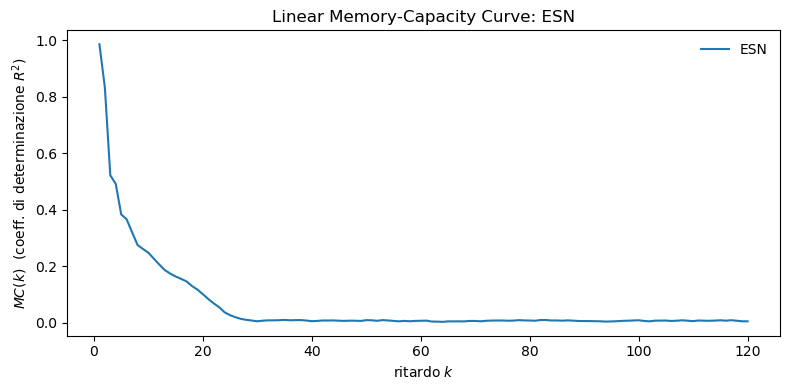

In [25]:

best = {
    'res_size':   702,
    'rho':        0.2984420995798068,
    'sparsity':   0.018373476919717507,
    'in_scale':   0.11767292203090399,
    'alpha':      0.46063074737767395,
    'ridge_reg':  1.0027704994452981e-06,
    'topo':       'double_cycle',
}

SEED    = 42
in_size = 1
out_size= 1
N       = best['res_size']

esn = ESN(
    in_size         = in_size,
    res_size        = N,
    out_size        = out_size,
    spectral_radius = best['rho'],
    sparsity        = best['sparsity'],
    input_scaling   = best['in_scale'],
    leak_rate       = best['alpha'],
    ridge_reg       = best['ridge_reg'],
    seed            = SEED,
    topology        = best['topo']
)

T_warm = 200
T_eval = 4000
rng = np.random.default_rng(SEED)
u_seq = rng.choice([-1.0, +1.0], size=T_warm + T_eval)

esn.fit(
    u_seq[:T_warm].reshape(-1,1),
    u_seq[:T_warm].reshape(-1,1),
    washout=0
)

# Raccogliamo gli stati interni per i successivi 4000 passi
states_esn   = np.zeros((T_eval, N))
x_esn = np.zeros(N)

for t in range(T_eval):
    u_in = np.array([u_seq[T_warm + t]])
    x_esn   = esn._update(x_esn, u_in)
    states_esn[t]   = x_esn

max_k     = 120
eps_ridge = 1e-8

R2_esn = []

for k in range(1, max_k + 1):
    # target u(t−k) allineato su [T_warm, T_warm+T_eval)
    targets = u_seq[T_warm - k : T_warm + T_eval - k]  # lunghezza = T_eval

    # Ridge closed‐form: X = states_esn (T_eval, N)
    X = states_esn
    XtX = X.T @ X
    reg = eps_ridge * np.eye(N)
    W_ridge_esn = np.linalg.solve(XtX + reg, X.T @ targets)  # (N,)
    pred_esn = X @ W_ridge_esn

    var_t   = np.var(targets)
    R2_k_esn = 0.0 if var_t == 0 else 1 - np.var(targets - pred_esn) / var_t
    R2_esn.append(R2_k_esn)

MC_total_esn   = np.sum(R2_esn)

print(f"Total linear MC (ESN) ≈ {MC_total_esn:.2f}  (upper bound = {N})")


ks = np.arange(1, max_k + 1)

plt.figure(figsize=(8,4))
plt.plot(ks, R2_esn,   label="ESN",   lw=1.5)
plt.xlabel("ritardo $k$")
plt.ylabel("$MC(k)$  (coeff. di determinazione $R^2$)")
plt.title("Linear Memory‐Capacity Curve: ESN")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

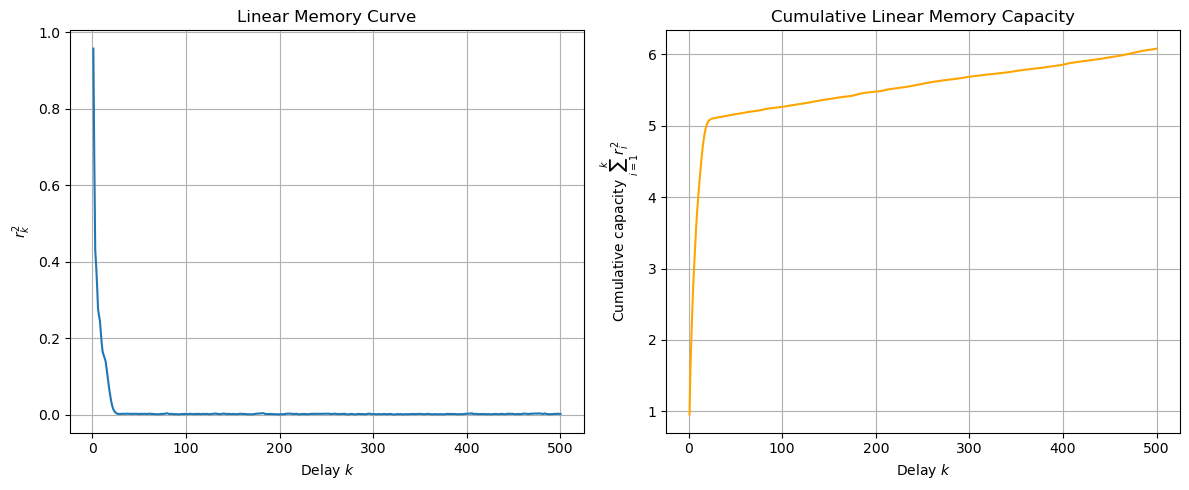

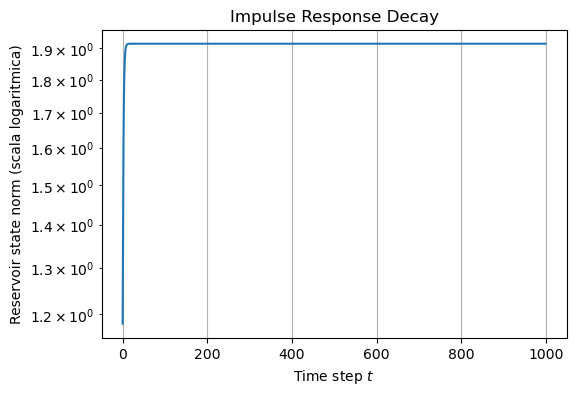

Ritardo k* (r_k^2 < 0.01): 24
Capacità lineare totale (∑ r_k^2): 6.0795
Capacità normalizzata (MC / N): 0.008660
Costante di decadimento stimata τ: -379.45 time steps


In [43]:
np.random.seed(42)

def compute_memory_curve(esn, delay_max=500, washout=100, input_length=10000):
    rng = np.random.default_rng(0)
    # Sequenza di input casuale u(t) ∈ [-1,1]
    U = rng.uniform(-1, 1, size=(input_length, esn.in_size))
    
    # Colleziono stati dopo washout
    states = np.zeros((input_length - washout, esn.res_size))
    x = np.zeros(esn.res_size)
    for t in range(input_length):
        u = np.atleast_1d(U[t])
        x = esn._update(x, u)
        if t >= washout:
            states[t - washout] = x
    U_trim = U[washout:]
    
    # Calcolo r_k^2 per ogni ritardo k
    r2 = np.zeros(delay_max)
    for k in range(1, delay_max + 1):
        if k >= len(U_trim):
            break
        X_k = states[k:]            # (T - washout - k, res_size)
        target = U_trim[:-k, 0]     # Ricostruiamo prima componente di U
        # Disegno la matrice di progetto X_design = [1, x(t)]
        X_design = np.hstack((np.ones((X_k.shape[0], 1)), X_k))
        # Ridge closed-form: w = (X^T X + α I)^{-1} X^T y
        alpha = esn.ridge_reg
        XtX = X_design.T.dot(X_design)
        reg = alpha * np.eye(XtX.shape[0])
        w = np.linalg.inv(XtX + reg).dot(X_design.T).dot(target)
        preds = X_design.dot(w)
        r, _ = pearsonr(preds, target)
        r2[k-1] = r**2
    return r2

def plot_memory_curve(r2):
    k = np.arange(1, len(r2) + 1)
    cum_capacity = np.cumsum(r2)
    
    plt.figure(figsize=(12, 5))
    
    # Plot 1: r_k^2 vs k
    plt.subplot(1, 2, 1)
    plt.plot(k, r2, label=r"$r_k^2$")
    plt.xlabel("Delay $k$")
    plt.ylabel(r"$r_k^2$")
    plt.title("Linear Memory Curve")
    plt.grid(True)
    
    # Plot 2: capacità cumulativa vs k
    plt.subplot(1, 2, 2)
    plt.plot(k, cum_capacity, label="Cumulative capacity", color='orange')
    plt.xlabel("Delay $k$")
    plt.ylabel(r"Cumulative capacity $\sum_{i=1}^k r_i^2$")
    plt.title("Cumulative Linear Memory Capacity")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def compute_impulse_response(esn, time_steps=1000):

    U = np.zeros((time_steps, esn.in_size))
    U[0] = np.ones(esn.in_size)
    
    x = np.zeros(esn.res_size)
    norms = np.zeros(time_steps)
    for t in range(time_steps):
        u = U[t]
        x = esn._update(x, u)
        norms[t] = np.linalg.norm(x)
    return norms

def plot_impulse_response(norms):
    t = np.arange(len(norms))
    plt.figure(figsize=(6, 4))
    plt.semilogy(t, norms, label=r"$\|x(t)\|$")
    plt.xlabel("Time step $t$")
    plt.ylabel(r"Reservoir state norm (scala logaritmica)")
    plt.title("Impulse Response Decay")
    plt.grid(True)
    plt.show()

best_params = {
    'res_size': 702,
    'rho': 0.2984420995798068,
    'sparsity': 0.018373476919717507,
    'in_scale': 0.11767292203090399,
    'alpha': 0.46063074737767395,
    'ridge_reg': 1.0027704994452981e-06,
    'topo': 'double_cycle',
}


esn = ESN(
    in_size=1,
    res_size=best_params['res_size'],
    out_size=1,
    spectral_radius=best_params['rho'],
    sparsity=best_params['sparsity'],
    input_scaling=best_params['in_scale'],
    leak_rate=best_params['alpha'],
    ridge_reg=best_params['ridge_reg'],
    topology=best_params['topo'],
    seed=42
)

r2_curve = compute_memory_curve(esn, delay_max=500, washout=100, input_length=10000)

plot_memory_curve(r2_curve)

norms = compute_impulse_response(esn, time_steps=1000)
plot_impulse_response(norms)
epsilon = 0.01
indices = np.where(r2_curve < epsilon)[0]
k_star = indices[0] + 1 if len(indices) > 0 else None

total_MC = np.sum(r2_curve)
normalized_MC = total_MC / esn.res_size

T_fit = 50
t_fit = np.arange(T_fit)
y_fit = norms[:T_fit]
coeffs = np.polyfit(t_fit, np.log(y_fit), 1)
q, lnA = coeffs
tau_est = -1.0 / q
print(f"Ritardo k* (r_k^2 < {epsilon}): {k_star}")
print(f"Capacità lineare totale (∑ r_k^2): {total_MC:.4f}")
print(f"Capacità normalizzata (MC / N): {normalized_MC:.6f}")
print(f"Costante di decadimento stimata τ: {tau_est:.2f} time steps")

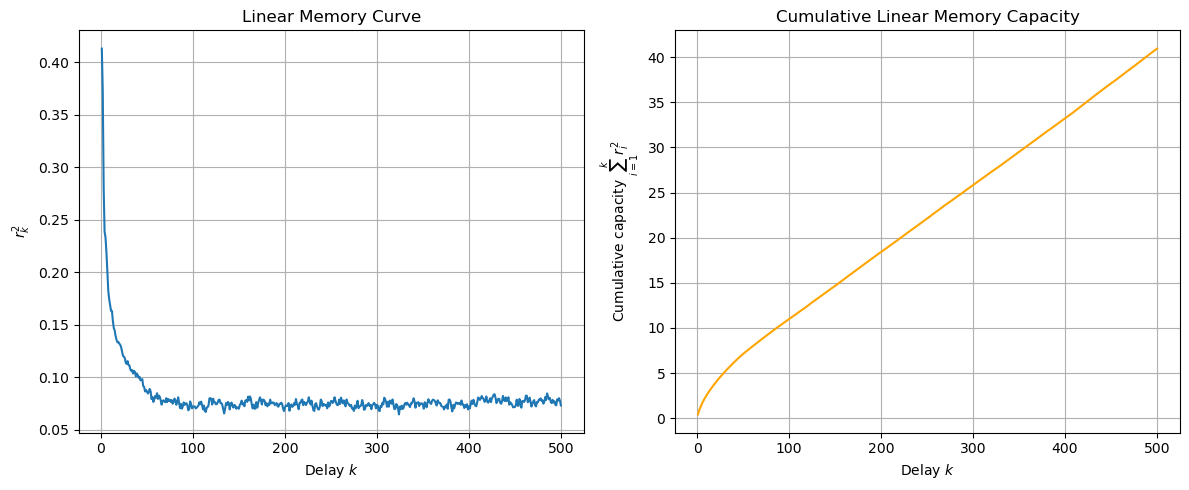

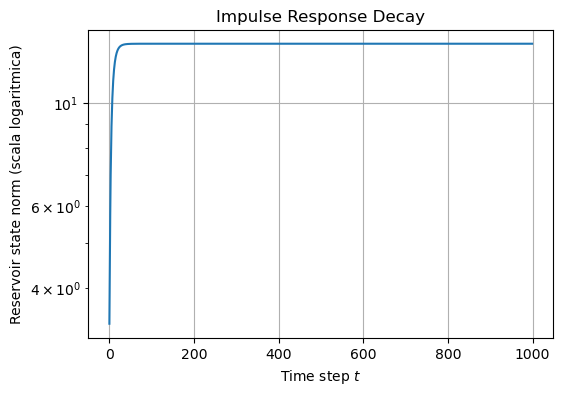

Ritardo k* (r_k^2 < 0.01): None
Capacità lineare totale (∑ r_k^2): 40.9534
Capacità normalizzata (MC / N): 0.058338
Costante di decadimento stimata τ: -391.27 time steps


In [27]:
best_params_2 = {
    'res_size': 702,
    'rho': 0.99,
    'sparsity': 1,
    'in_scale': 0.9,
    'alpha': 0.2,
    'ridge_reg': 1.0027704994452981e-06,
    'topo': 'double_cycle',
}

esn_2 = ESN(
    in_size=3,
    res_size=best_params_2['res_size'],
    out_size=3,
    spectral_radius=best_params_2['rho'],
    sparsity=best_params_2['sparsity'],
    input_scaling=best_params_2['in_scale'],
    leak_rate=best_params_2['alpha'],
    ridge_reg=best_params_2['ridge_reg'],
    topology=best_params_2['topo'],
    seed=42
)

r2_curve_2 = compute_memory_curve(esn_2, delay_max=500, washout=100, input_length=10000)

plot_memory_curve(r2_curve_2)

norms_2 = compute_impulse_response(esn_2, time_steps=1000)
plot_impulse_response(norms_2)

epsilon = 0.01
indices = np.where(r2_curve_2 < epsilon)[0]
k_star = indices[0] + 1 if len(indices) > 0 else None

total_MC_2 = np.sum(r2_curve_2)
normalized_MC_2 = total_MC_2 / esn_2.res_size

T_fit = 50
t_fit = np.arange(T_fit)
y_fit = norms[:T_fit]
coeffs = np.polyfit(t_fit, np.log(y_fit), 1)
q, lnA = coeffs
tau_est = -1.0 / q

print(f"Ritardo k* (r_k^2 < {epsilon}): {k_star}")
print(f"Capacità lineare totale (∑ r_k^2): {total_MC_2:.4f}")
print(f"Capacità normalizzata (MC / N): {normalized_MC_2:.6f}")
print(f"Costante di decadimento stimata τ: {tau_est:.2f} time steps")

# print MC 